In [1]:
%pylab inline
%load_ext autoreload 
%autoreload 2

from __future__ import division 

import os 
import copy
import numpy as np
from scipy import interpolate

# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 1.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 1.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 1.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 1.5
rc('axes', linewidth=2)

from astropy.io import fits 
from astropy import units as u

# Cubehelix color scheme from https://github.com/jradavenport/cubehelix
import cubehelix  

# Change the maximum number of open files
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, -1))

Populating the interactive namespace from numpy and matplotlib


# Show Examples of the Sky Spectra from BOSS DR12
## Learn the basic data structures 

In [2]:
# Examples of sky spectra from BOSS DR12
skyFits1 = 'spec-3586-55181-0012.fits'
skyFits2 = 'spec-3586-55181-0014.fits' 

skyData1 = fits.open(skyFits1)
skyData2 = fits.open(skyFits2)

# Example of sky fiber catalog
skyCat = 'boss_sky_dr12_test.fit'

# Data Structure of the Spectra 
skyData1.info()

# HDU 1:COADD is the most useful one 
# HDU 4-17: Individual frames (spCFrame) with calibration array, can be converted into electron unit: 
# See: http://data.sdss3.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html

Filename: spec-3586-55181-0012.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     125   ()              
1    COADD       BinTableHDU     26   4624R x 8C   [E, E, E, J, J, E, E, E]   
2    SPALL       BinTableHDU    474   1R x 232C    [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 6A, 6A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5

In [3]:
# Load in the Coadded Sky Data 
skyCoadd1 = skyData1[1].data 
skyCoadd2 = skyData2[1].data 

# This is the primary header
skyHeader1   = skyData1[0].header
skyHeader2   = skyData2[0].header

# This is the header that shows the data structure 
coaddHeader1 = skyData1[1].header
coaddHeader2 = skyData2[1].header

In [4]:
skyHeader1

# MJD     --> The date of observation
# PLATEID --> Plate ID 
# VACUUM  --> Wavelength in vacuum 
# BUNIT   = '1E-17 erg/cm^2/s/Ang'
# PLUG_RA, PLUG_DEC --> RA, DEC of the fiber 

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
BOSSVER = 'branch_jme-rewrite+svn105958' / ICC version                          
MJD     =                55181 / APO MJD day at start of exposure               
MJDLIST = '55181   '           /                                                
RA      =             8.001738 / RA of telescope boresight (deg)                
DEC     =             0.001221 / Dec of telescope boresight (deg)               
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '        

In [5]:
coaddHeader1
# Dimension 1: Flux (after background subtraction)
# Dimension 2: logWavelength 
# Dimension 3: Inverse variance 
# Dimension 4: Mask (Whihc pixels are bad)
# Dimension 7: Sky spectrum

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 4624 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

In [6]:
# Data structure 
skyCoadd1

FITS_rec([ (-1.5589867, 3.5517001, 0.011037054, 0, 67108864, 1.4864297, 8.3622561, 0.16232821),
       (6.645359, 3.5518, 0.04103053, 0, 0, 1.4868215, 7.1968694, 0.16221261),
       (3.8692131, 3.5518999, 0.039995886, 0, 0, 1.4871577, 7.0265307, 0.1621853),
       ...,
       (1.0569414, 4.0138001, 0.093732469, 0, 0, 0.79698294, 9.3400459, 0.15880923),
       (1.5448667, 4.0138998, 0.096821792, 0, 0, 0.79664665, 13.088336, 0.22122042),
       (3.0753689, 4.0139999, 0.089163251, 0, 0, 0.79631186, 16.580694, 0.21754959)], 
      dtype=[('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')])

## Plot the Sky Spectra 

In [7]:
# Convert the wavelength into linear wavelength 
lambda1  = 10.0 ** skyCoadd1['loglam']
# This is the sky residual flux 
skyRes1 = skyCoadd1['flux']
# This is the estimated sigma 
skySig1 = 1.0 / np.sqrt(skyCoadd1['ivar'])
# This is the origin 
skyOri1 = (skyCoadd1['flux'] + skyCoadd1['sky'])

lambda2  = 10.0 ** skyCoadd2['loglam']
skyRes2 = skyCoadd2['flux']
skySig2 = 1.0 / np.sqrt(skyCoadd2['ivar'])
skyOri2 = (skyCoadd2['flux'] + skyCoadd2['sky'])

In [8]:
skyDiff = (skyOri1 - skyOri2)

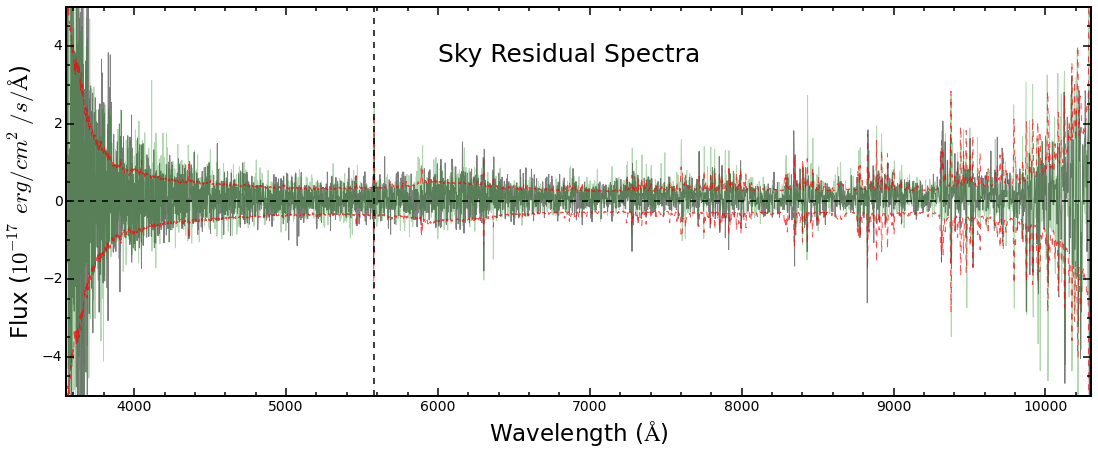

In [9]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3550.0, 10300.0)
ax.set_ylim(-5.0, 5.0)

# Sky residual
ax.plot(lambda1, skyRes1, '-', color='k', label='skyRes1', alpha=0.5)
ax.plot(lambda2, skyRes2, '-', color='g', label='skyRes2', alpha=0.3)

# Sigma of the spectra
ax.plot(lambda1, skySig1, '--', color='r', label='skySig1', alpha=0.7)
ax.plot(lambda1, -1.0 * skySig1, '--', color='r', label='skySig1', 
        alpha=0.7)

# The 5577A Line
ax.axhline(0.0,    linestyle='--', color='k', linewidth=1.5)
ax.axvline(5577.0, linestyle='--', color='k', linewidth=1.5)

ax.text(6000, 3.6, 'Sky Residual Spectra', fontsize=25)
# Put legend on
#ax.legend(loc=[0.06, 0.58], fontsize=20)

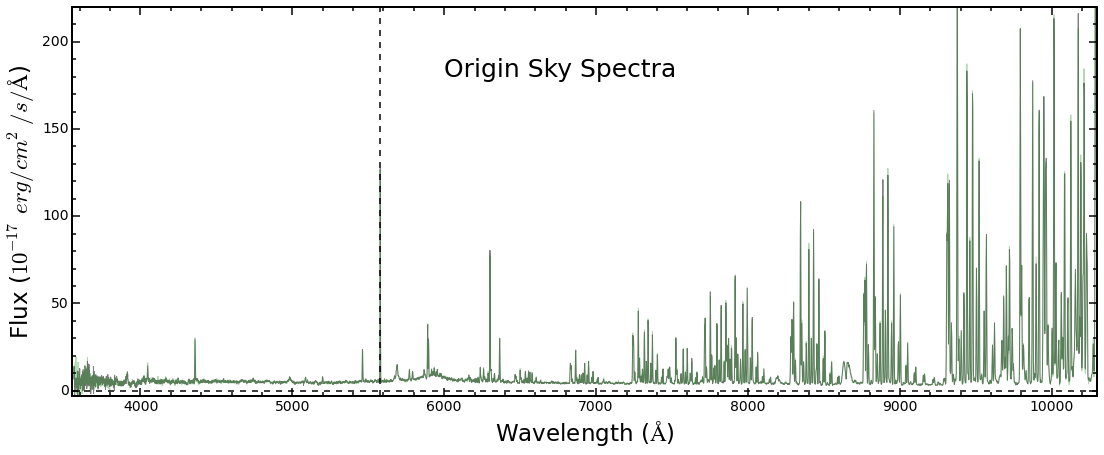

In [10]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3550.0, 10300.0)
ax.set_ylim(-3.0, 220.0)

# Origin Sky Spectra 
ax.plot(lambda1, skyOri1, '-', color='k', label='skyOri1', alpha=0.5)
ax.plot(lambda2, skyOri2, '-', color='g', label='skyOri2', alpha=0.3)

# 5577\AA Strong Line
ax.axhline(0.0,    linestyle='--', color='k', linewidth=1.5)
ax.axvline(5577.0, linestyle='--', color='k', linewidth=1.5)

ax.text(6000, 180, 'Origin Sky Spectra', fontsize=25)

# Put legend on
#ax.legend(loc=[0.06, 0.58], fontsize=20)

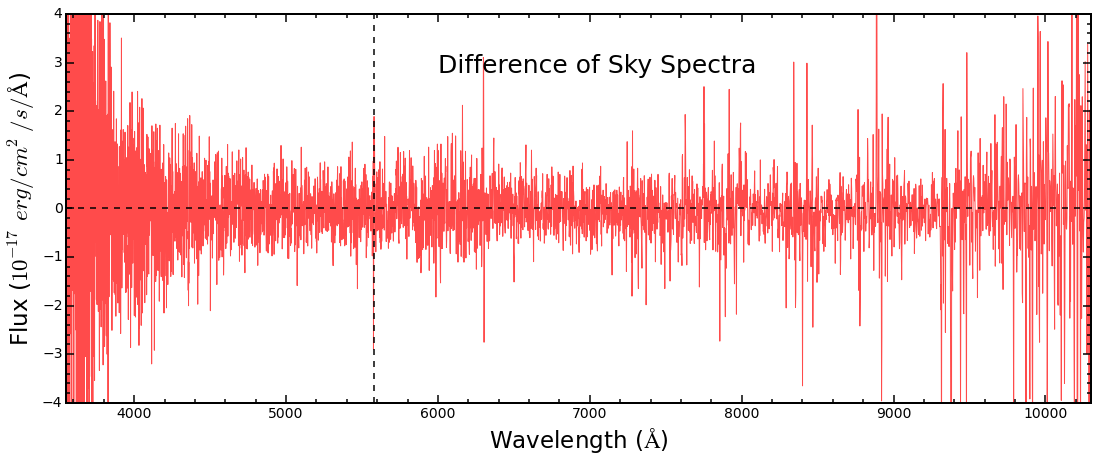

In [11]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3550.0, 10300.0)
ax.set_ylim(-4.0, 4.0)

# Difference of two Sky Spectra 
ax.plot(lambda2, skyDiff, '-', color='r', label='skyDiff', alpha=0.7)

# 5577\AA Strong Line
ax.axhline(0.0,    linestyle='--', color='k', linewidth=1.5)
ax.axvline(5577.0, linestyle='--', color='k', linewidth=1.5)

ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
#ax.legend(loc=[0.06, 0.58], fontsize=20)

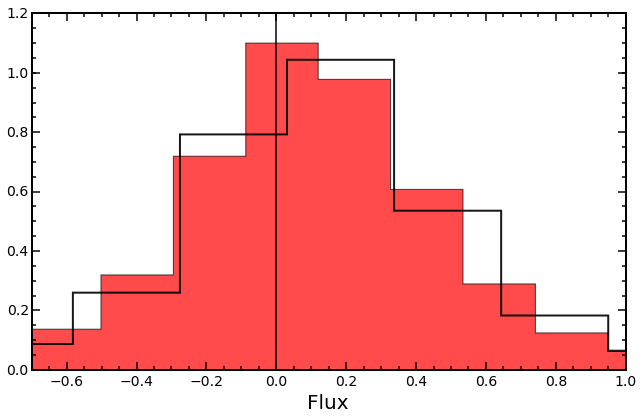

In [12]:
# Histogram of Sky Residual Pixel Values

from astroML.plotting import hist
import scipy 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

ax.set_xlim(-0.7, 1.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

counts1, bins2, patches3 = hist(skyRes1, bins='knuth', ax=ax, alpha=0.7, 
                                color='r', histtype='stepfilled', normed=True)
counts1, bins2, patches3 = hist(skyRes2,  bins='knuth', ax=ax, alpha=0.9, 
                                color='k', histtype='step', normed=True, linewidth=2)

ax.axvline(0.0, linestyle='-', color='k', linewidth=1.5)

ax.set_xlabel('Flux', fontsize=20)

# Read A List of Sky Spectra

In [245]:
def locateSkyInd(skyList, string): 
    """
    Find the index of spectra that contain certain string
    
    """
    found = []
    for ii, spec in enumerate(skyList):
        if string.strip() in spec.strip(): 
            found.append(ii)
            
    return found


def specInterp1D(waveIn, dataIn, waveNew, kind='linear'):
    """
    Resample the spectra into a new wavelength grid using 
    1-D interpolation 
    
    """
    if len(waveIn) != len(dataIn): 
        raise Exception("### Wavelength and Data should have the same dimension!")
    # Function to do interpolation 
    f = interpolate.interp1d(waveIn, dataIn, kind=kind)
    
    return f(waveNew)


def listAllSpec(root): 
    """
    Search all spec-***.fits files under a folder 
    Return as a list 
    
    """
    import glob 
    
    if root[-1] is not '/': 
        root = root + '/'
    searchDir = root + 'spec-*.fits'
    
    return glob.glob(searchDir)
    
    
def batchReadSky(root, minWave=3700.0, maxWave=10300.0, dw=1.0): 
    """    
    Read in a BOSS Sky Spectra, return the origin sky spectra 
    and the residual spectra 
    
    """
    if os.path.exists(root): 
        skyList = listAllSpec(root)
        nSky = len(skyList)
        print "### %d Sky Spectra will be read in" % nSky
    else: 
        raise Exception("### %s does not exist!" % root)
        
    nWave = int((maxWave - minWave) / dw)
    newWave = np.linspace(minWave, maxWave, nWave)
    
    oriArr = np.zeros((nSky, nWave))
    resArr = np.zeros((nSky, nWave))
    sigArr = np.zeros((nSky, nWave))
    weiArr = np.ones((nSky, nWave))
    flagArr = np.ones(nSky, dtype=bool)

    for ii, spec in enumerate(skyList): 
        
        skyHdu  = fits.open(spec)
        skyData = skyHdu[1].data 
        # Convert the wavelength into linear wavelength 
        wave = (10.0 ** skyData['loglam'])
        if (np.nanmin(wave) > minWave) or (np.nanmax(wave) < maxWave): 
            print "### %s - %7.1f - %7.1f: Excluded!" % (spec, np.nanmin(wave), np.nanmax(wave))
            flagArr[ii] = False
        else: 
            # This is the sky residual flux 
            res = (skyData['flux'])
            # This is the variance
            sig = (1.0 / np.sqrt(skyData['ivar']))
            # This is the origin 
            ori = (skyData['flux'] + skyData['sky'])
            skyHdu.close(closed=True) 
        
            # Resampling 
            oriNew = specInterp1D(wave, ori, newWave) 
            resNew = specInterp1D(wave, res, newWave)
            sigNew = np.sqrt(specInterp1D(wave, sig**2.0, newWave))
        
            # Setup a very BAD mask 
            indMsk = (oriNew < 0.001) & (~np.isfinite(oriNew)) & (sigNew == 0)
            oriNew[indMsk] = np.nan
            resNew[indMsk] = np.nan 
            sigNew[indMsk] = np.nan 
        
            oriArr[ii, :] = oriNew
            resArr[ii, :] = resNew
            sigArr[ii, :] = sigNew
            weiArr[ii, (indMsk)] = 0.0        

    return (newWave, oriArr, resArr, sigArr, weiArr, flagArr)

In [246]:
# Test: MJD = 56768: 
# XXX Read large number of files seem to cause problems
# May have something to do with astropy.fits does not correctly close file 
# In shell, set:  > ulimit -n 1024
root = '/Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/'
lam, ori, res, sig, wei, flag = batchReadSky(root)

### 419 Sky Spectra will be read in
### /Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/spec-7455-56768-0455.fits -  3608.3 - 10242.4: Excluded!
### /Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/spec-7455-56768-0529.fits -  3611.6 -  9837.8: Excluded!
### /Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/spec-7455-56768-0875.fits -  3612.4 - 10139.1: Excluded!
### /Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/spec-7455-56768-0978.fits -  3611.6 - 10216.5: Excluded!


/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:78: RuntimeWarning: divide by zero encountered in true_divide


In [247]:
# Keep the useful ones
ori = ori[flag]
res = res[flag]
sig = sig[flag]
wei = wei[flag]
print "### %d Sky Spectra are left in the sample" % len(ori)

### 415 Sky Spectra are left in the sample


In [248]:
skyList = listAllSpec(root)

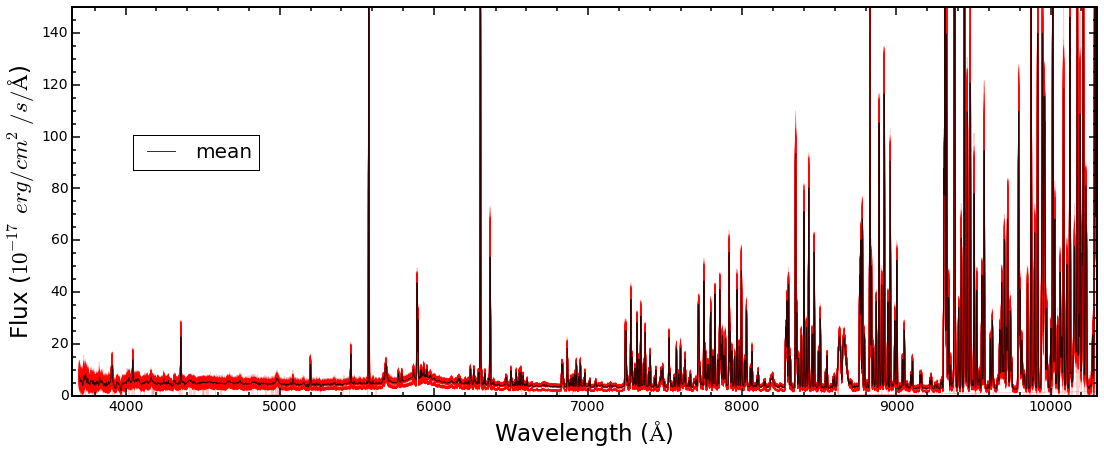

In [249]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3650.0, 10300.0)
ax.set_ylim(0.0, 150.0)

# Difference of two Sky Spectra 
for flux in ori:
    ax.plot(lam, flux, '-', color='r', alpha=0.2)

ax.plot(lam, np.nanmean(ori, axis=0), '-', color='k', alpha=0.8, label='mean')

# Put legend on
ax.legend(loc=[0.06, 0.58], fontsize=20)

In [250]:
from sklearn.decomposition import PCA as PCA

In [251]:
sky_mean = np.nanmean(ori, axis=0)

In [252]:
pca = PCA(300)
pca.fit(ori)

PCA(copy=True, n_components=300, whiten=False)

In [253]:
pca_comp = np.vstack([sky_mean, pca.components_])

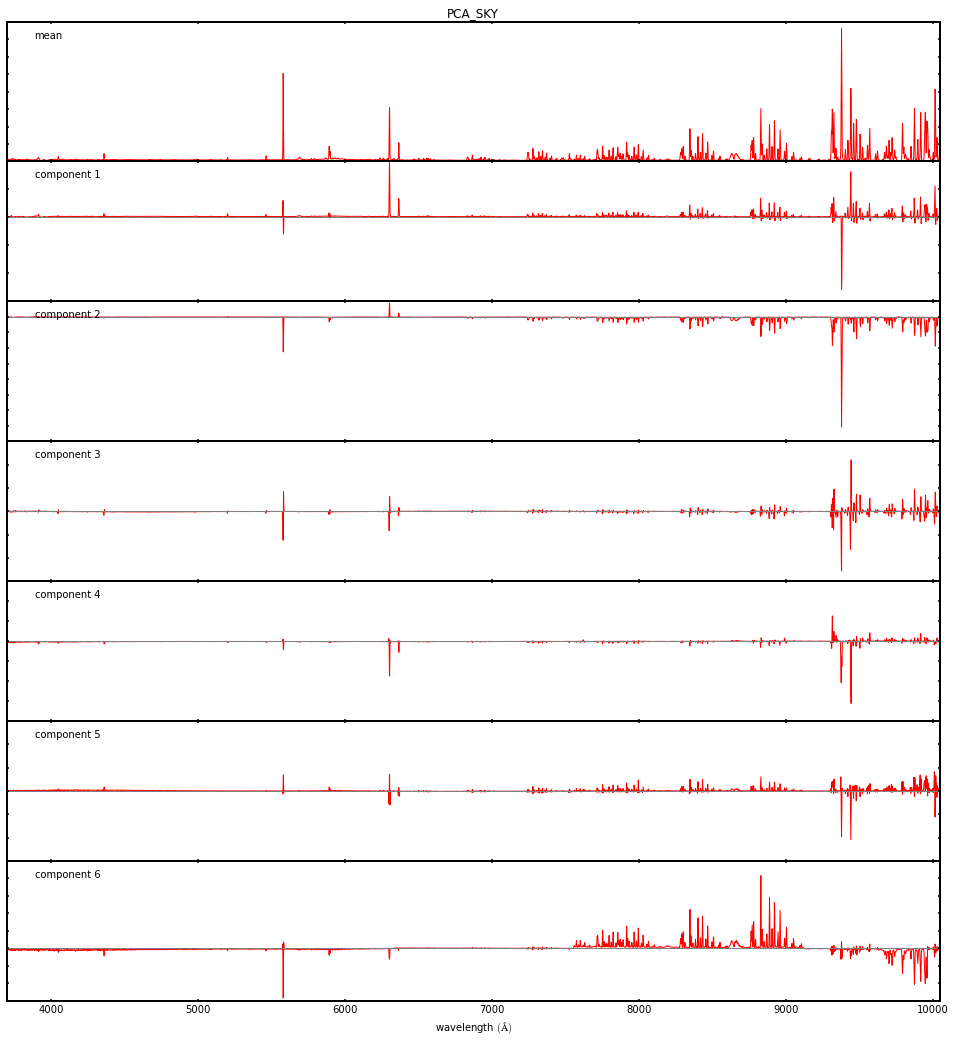

In [254]:
n_components = 7

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
for j in range(n_components):
    
    ax = fig.add_subplot(7,1,j+1)

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    if j < n_components - 1:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

    ax.plot(lam, pca_comp[j], '-r', lw=1)

    # plot zero line
    xlim = [3700, 10050]
    ax.plot(xlim, [0, 0], '-', c='gray', lw=1)
    ax.set_xlim(xlim)

    if j == 0:
        ax.set_title('PCA_SKY')

    if j == 0:
        label = 'mean'
    else:
        label = 'component %i' % j

    ax.text(0.03, 0.94, label, transform=ax.transAxes,
            ha='left', va='top')

    for l in ax.get_xticklines() + ax.get_yticklines(): 
        l.set_markersize(2) 

In [256]:
evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()
print evals

[  5.12664902e-01   3.10151568e-01   7.16153758e-02   4.09305052e-02
   1.42591798e-02   8.67897417e-03   6.60208678e-03   6.19519781e-03
   3.82740345e-03   3.37012812e-03   2.15418920e-03   1.88199142e-03
   1.48809801e-03   1.28385721e-03   1.04909855e-03   8.79190810e-04
   7.10302949e-04   5.63270110e-04   4.51803859e-04   4.42872456e-04
   4.10112654e-04   3.28611245e-04   3.00343876e-04   2.84682795e-04
   2.72374447e-04   2.47757068e-04   2.26693967e-04   2.10664574e-04
   1.95064060e-04   1.88948179e-04   1.72110484e-04   1.70689727e-04
   1.58269389e-04   1.52084902e-04   1.47392919e-04   1.42948466e-04
   1.30005635e-04   1.24703900e-04   1.15851497e-04   1.14376310e-04
   1.08542651e-04   1.00519077e-04   9.90185105e-05   9.30040927e-05
   8.94667965e-05   8.85323327e-05   8.49692877e-05   8.21790792e-05
   8.18729347e-05   7.61689204e-05   7.32730217e-05   7.20966420e-05
   6.82932637e-05   6.72974212e-05   6.41418598e-05   6.36805107e-05
   6.21351222e-05   6.09321620e-05

(3700, 10300)

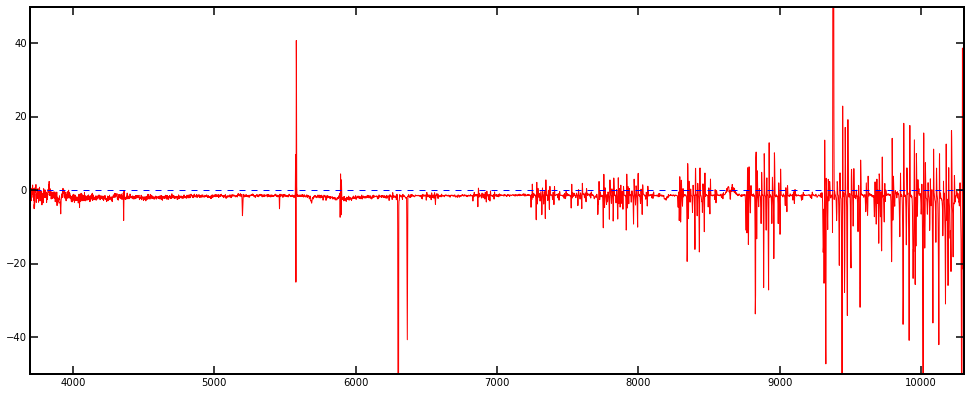

In [260]:
# Recontruct an spectrum 
# e.g. spec-7455-56768-0743.fits
#np.where(skyList == '/Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/spec-7455-56768-0743.fits')
skyTest = ori[0]
resTest = res[0]
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
ax = gca()
ax.plot(lam, (skyTest - sky_mean), c='r')
ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)
ax.set_ylim(-50.0, 50.0)
ax.set_xlim(3700, 10300)

In [261]:
evecs = pca.components_
coeff = np.dot(evecs, (skyTest - sky_mean))
skyRec = (sky_mean + np.dot(coeff[:], evecs[:]))

(3700, 10300)

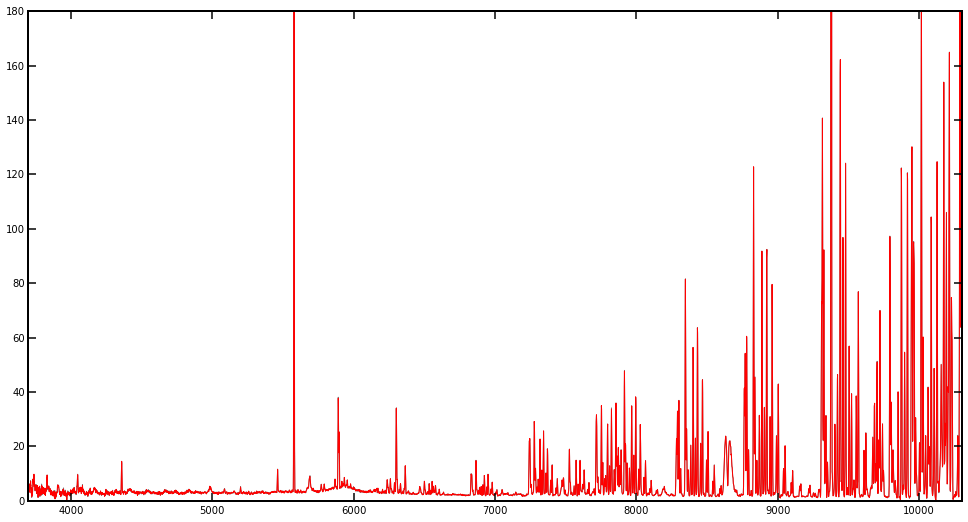

In [262]:
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
ax = gca()
ax.plot(lam, skyTest, '-', c='gray')
ax.plot(lam, skyRec, '-r')
ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)
ax.set_ylim(-0.0, 180.0)
ax.set_xlim(3700, 10300)

(3700, 10300)

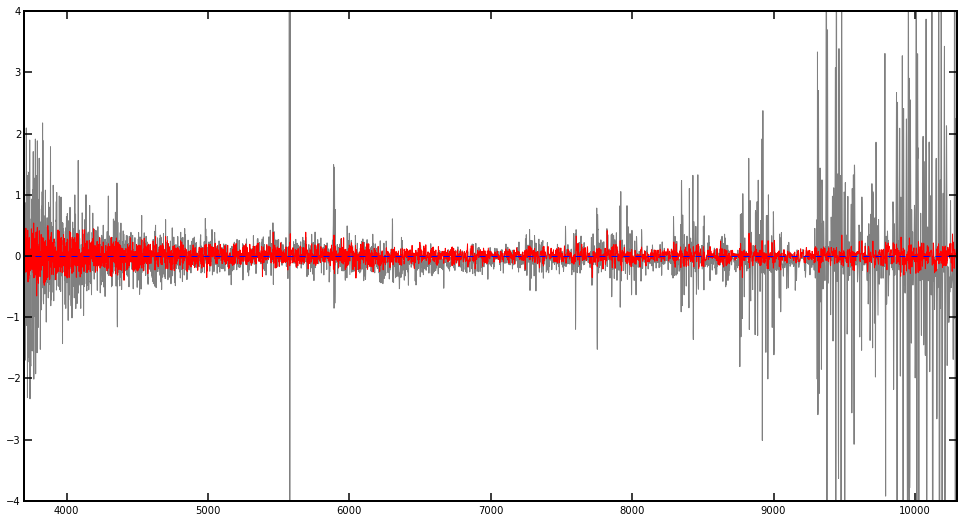

In [263]:
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
ax = gca()
ax.plot(lam, resTest, '-', c='gray')
ax.plot(lam, skyTest - skyRec, '-r')
ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)
ax.set_ylim(-4.0, 4.0)
ax.set_xlim(3700, 10300)

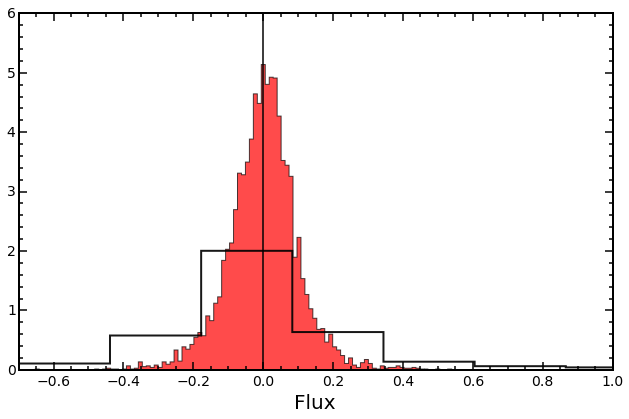

In [264]:
# Histogram of Sky Residual Pixel Values

from astroML.plotting import hist
import scipy 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1,
                    top=0.95, right=0.95)
ax = gca()
fontsize = 14
ax.minorticks_on()

ax.set_xlim(-0.7, 1.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

counts1, bins2, patches3 = hist(skyTest - skyRec, bins='knuth', ax=ax, alpha=0.7, 
                                color='r', histtype='stepfilled', normed=True)
counts1, bins2, patches3 = hist(resTest,  bins='knuth', ax=ax, alpha=0.9, 
                                color='k', histtype='step', normed=True, linewidth=2)

ax.axvline(0.0, linestyle='-', color='k', linewidth=1.5)

ax.set_xlabel('Flux', fontsize=20)

# Test of 1-D Resampling of Spectra

In [265]:
spec = '/Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/spec-7455-56768-0529.fits'
skyHdu = fits.open(spec)
skyData = skyHdu[1].data

In [266]:
wave = 10.0 ** skyData['loglam']
ori = skyData['sky']
msk = skyData['and_mask']

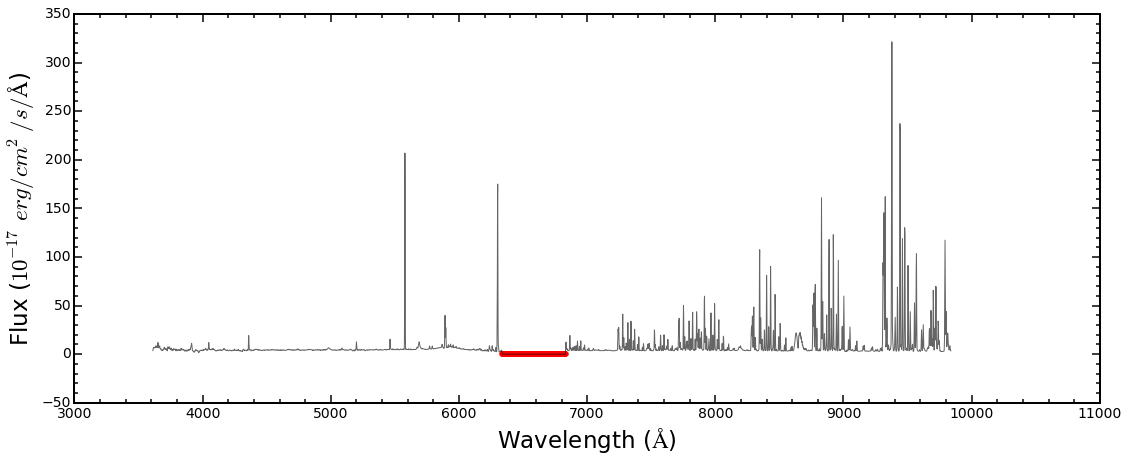

In [210]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

#ax.set_xlim(4550.0, 5000.0)
#ax.set_ylim(0.0, 6.0)

ax.plot(wave, ori, '-', color='k', alpha=0.6)
ax.scatter(wave[ori<0.01], ori[ori<0.01], color='r')
#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
#ax.legend(loc=[0.06, 0.58], fontsize=20)

In [62]:
minWave = 3700.0
maxWave = 10000.0 
dw = 1.0
waveNew = np.arange(int((maxWave - minWave)/dw)) * dw + minWave

In [86]:
wave = np.array(data['wave'])
ori  = np.array(data['ori'])
ivar  = np.array(data['ivar'])
sig  = 1.0 / np.sqrt(ivar)

In [87]:
oriNew = specInterp1D(wave, ori, waveNew)
sigNew = np.sqrt(specInterp1D(wave, sig**2.0, waveNew))

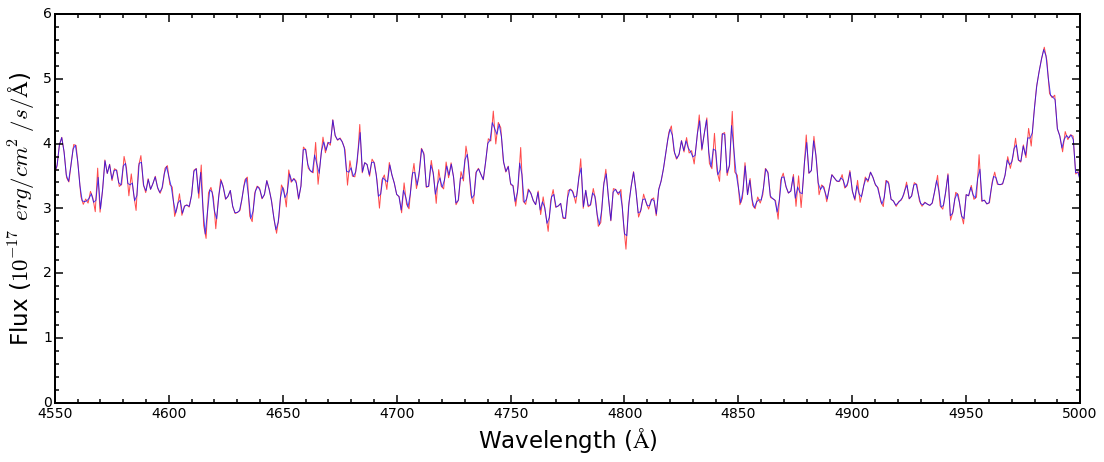

In [91]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(4550.0, 5000.0)
ax.set_ylim(0.0, 6.0)

# Difference of two Sky Spectra 
ax.plot(wave, ori, '-', color='r', label='ori', alpha=0.7)
ax.plot(waveNew, oriNew, '-', color='b', label='resample', alpha=0.7)

#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
#ax.legend(loc=[0.06, 0.58], fontsize=20)

# Object Test

## 1. QSO 

In [267]:
qso1 = '/Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/object/spec-7339-56768-0120.fits'

In [268]:
qsoHdu = fits.open(qso1)
qsoData = qsoHdu[1].data

w1 = 10.0 ** qsoData['loglam']
f1 = qsoData['flux']
s1 = qsoData['sky']
m1 = qsoData['model']

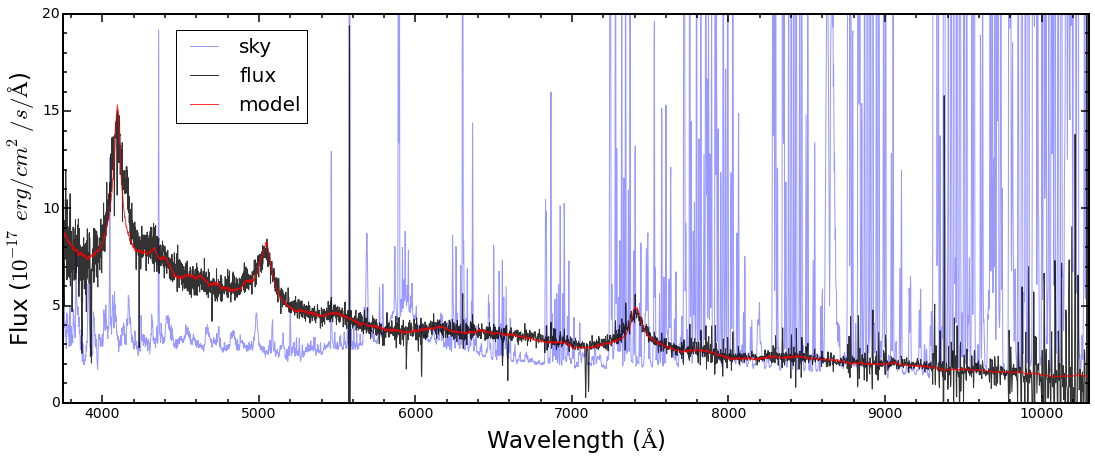

In [269]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3750.0, 10300.0)
ax.set_ylim(0.0, 20.0)

ax.plot(w1, s1, '-', color='b', alpha=0.4, label='sky')
ax.plot(w1, f1, '-', color='k', alpha=0.8, label='flux')
ax.plot(w1, m1, '-', color='r', alpha=0.8, label='model')

#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.11, 0.72], fontsize=20)

In [270]:
f1bin = specInterp1D(w1, f1, lam)
m1bin = specInterp1D(w1, m1, lam)
s1bin = specInterp1D(w1, s1, lam)
res1 = f1bin - m1bin

In [299]:
from astropy.convolution import convolve, Box1DKernel
res1_box = convolve(res1, Box1DKernel(60))

from scipy.signal import medfilt
res1_med = medfilt(res1, kernel_size=51)

# This is not perfect !!
res1_norm = res1 - res1_med

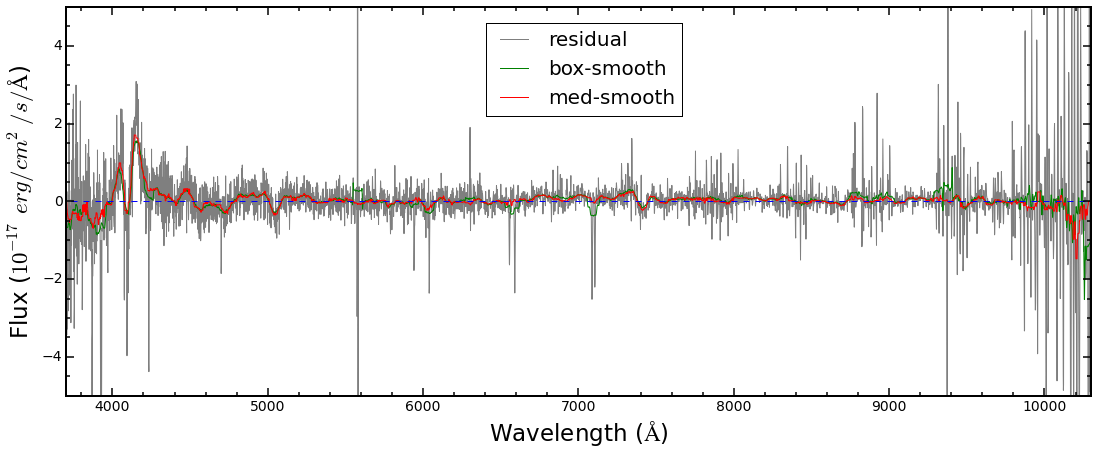

In [300]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3700.0, 10300.0)
ax.set_ylim(-5.0, 5.0)

ax.plot(lam, res1, '-', color='k', alpha=0.5, label='residual')
ax.plot(lam, res1_box, '-', color='g', alpha=1.0, label='box-smooth')
ax.plot(lam, res1_med, '-', color='r', alpha=1.0, label='med-smooth')


ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)

#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.41, 0.72], fontsize=20)

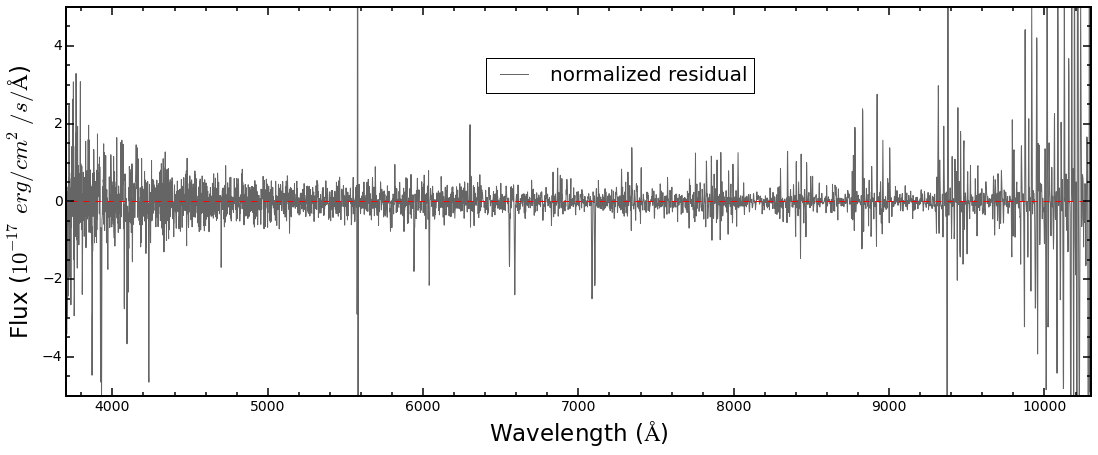

In [303]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3700.0, 10300.0)
ax.set_ylim(-5.0, 5.0)

ax.plot(lam, res1_norm, '-', color='k', alpha=0.6, label='normalized residual')
ax.plot([3000, 10300], [0, 0], '--', c='r', lw=1)


#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.41, 0.78], fontsize=20)

In [307]:
res1_coeff = np.dot(evecs, (res1_norm - sky_mean))
res1_skyrec = (sky_mean + np.dot(res1_coeff[:], evecs[:]))

res1_skynorm = medfilt(res1_skyrec, kernel_size=51)

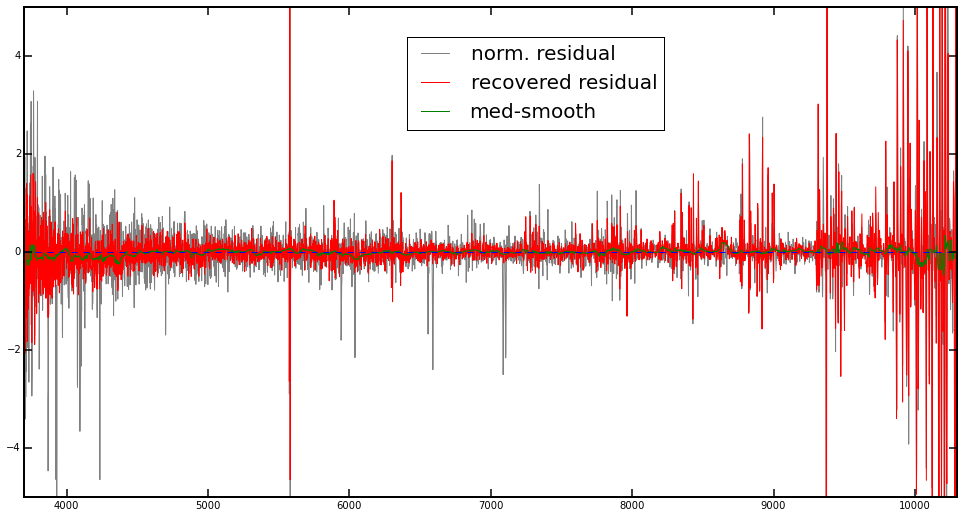

In [308]:
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
ax = gca()
ax.plot(lam, res1_norm, '-', c='gray', label='norm. residual')
ax.plot(lam, res1_skyrec, '-r', label='recovered residual')
ax.plot(lam, res1_skynorm, '-g', label='med-smooth')

ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)

ax.set_ylim(-5.0, 5.0)
ax.set_xlim(3700, 10300)

# Put legend on
ax.legend(loc=[0.41, 0.75], fontsize=20)

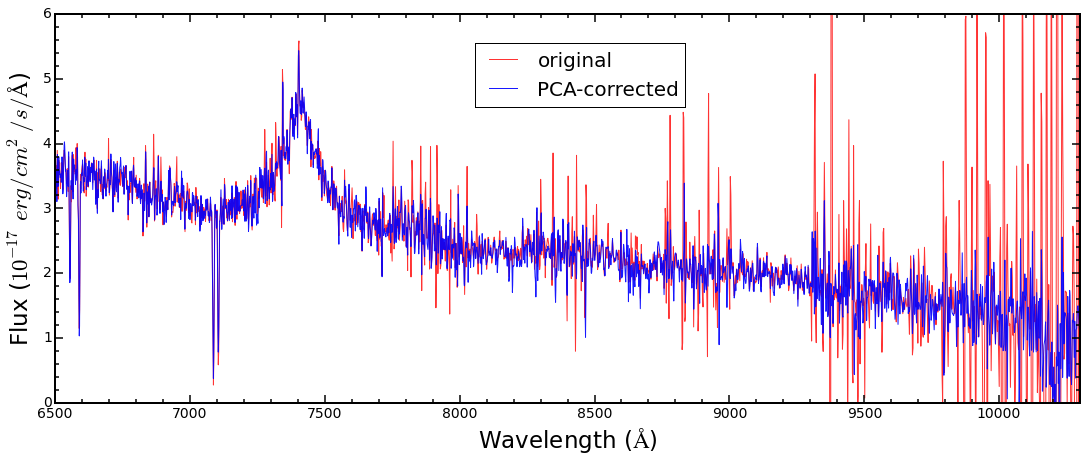

In [309]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(6500.0, 10300.0)
ax.set_ylim(0.0, 6.0)

ax.plot(w1, f1, '-', color='r', alpha=0.8, label='original')
ax.plot(lam, (f1bin - res1_skyrec), '-', color='b', alpha=0.9, label='PCA-corrected')


#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.41, 0.76], fontsize=20)

## 2. Star-forming galaxy at z~1

In [310]:
gal1 = '/Users/songhuang/Downloads/sdss_iv/sdss_sky/mjd56786/object/spec-7339-56768-0102.fits'

In [311]:
galHdu = fits.open(gal1)
galData = galHdu[1].data

w2 = 10.0 ** galData['loglam']
f2 = galData['flux']
s2 = galData['sky']
m2 = galData['model']

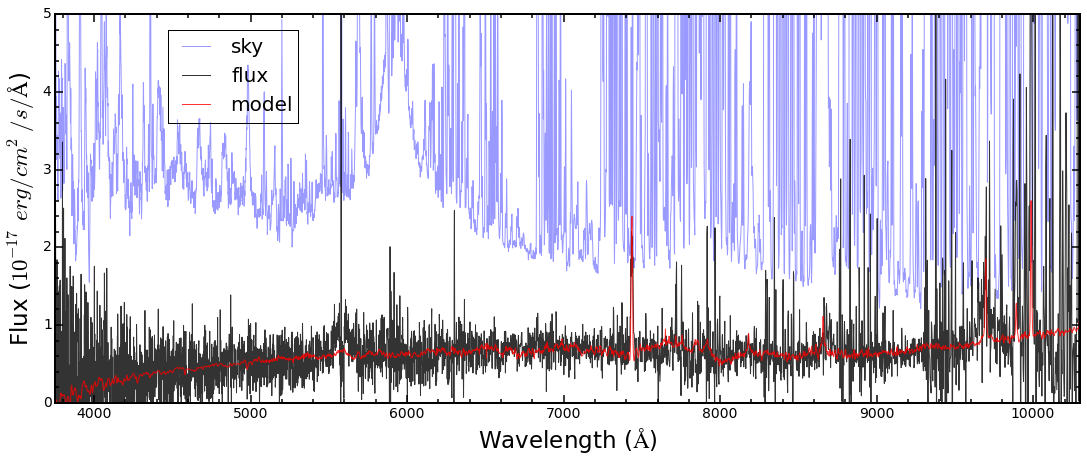

In [312]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3750.0, 10300.0)
ax.set_ylim(0.0, 5.0)

ax.plot(w2, s2, '-', color='b', alpha=0.4, label='sky')
ax.plot(w2, f2, '-', color='k', alpha=0.8, label='flux')
ax.plot(w2, m2, '-', color='r', alpha=0.8, label='model')

#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.11, 0.72], fontsize=20)

In [313]:
f2bin = specInterp1D(w2, f2, lam)
m2bin = specInterp1D(w2, m2, lam)
s2bin = specInterp1D(w2, s2, lam)
res2 = f2bin - m2bin

In [314]:
from astropy.convolution import convolve, Box1DKernel
res2_box = convolve(res2, Box1DKernel(50))

from scipy.signal import medfilt
res2_med = medfilt(res2, kernel_size=51)

# This is not perfect !!
res2_norm = res2 - res2_med

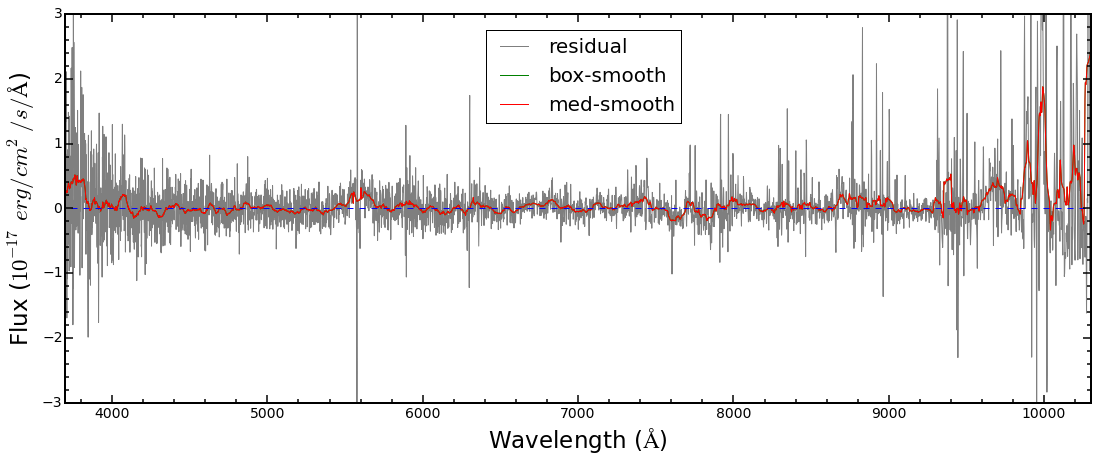

In [316]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3700.0, 10300.0)
ax.set_ylim(-3.0, 3.0)

ax.plot(lam, res2, '-', color='k', alpha=0.5, label='residual')
ax.plot(lam, res2_box, '-', color='g', alpha=1.0, label='box-smooth')
ax.plot(lam, res2_box, '-', color='r', alpha=1.0, label='med-smooth')

ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)

#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.41, 0.72], fontsize=20)

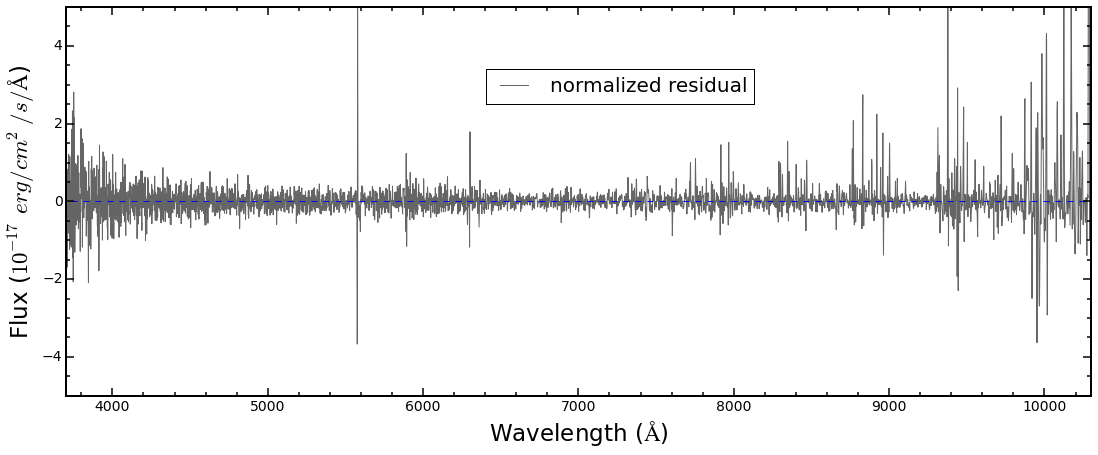

In [317]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(3700.0, 10300.0)
ax.set_ylim(-5.0, 5.0)

ax.plot(lam, res2_norm, '-', color='k', alpha=0.6, label='normalized residual')
ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)


#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.41, 0.75], fontsize=20)

In [319]:
res2_coeff = np.dot(evecs, (res2_norm - sky_mean))
res2_skyrec = (sky_mean + np.dot(res2_coeff[:], evecs[:]))

res2_skynorm = medfilt(res2_skyrec, kernel_size=51)

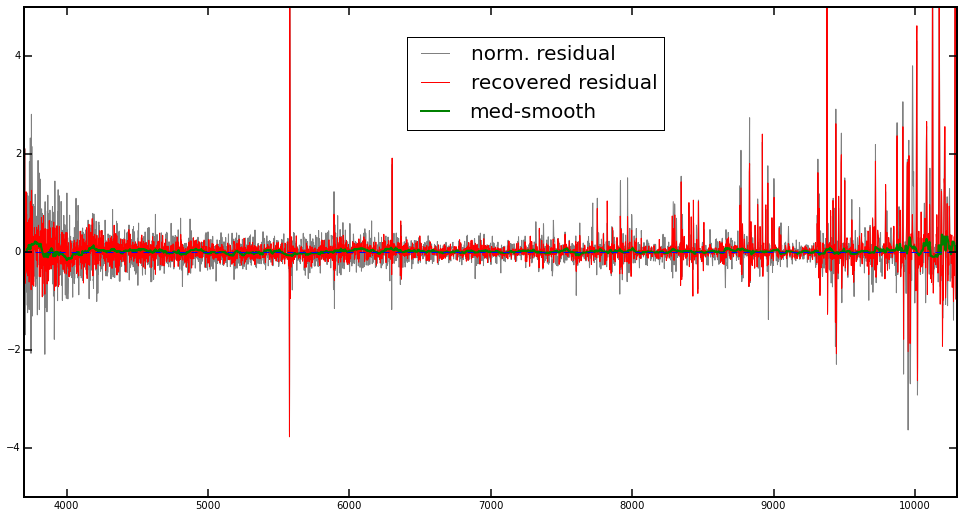

In [321]:
fig = plt.figure(figsize=(16, 8))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
ax = gca()
ax.plot(lam, res2_norm, '-', c='gray', label='norm. residual')
ax.plot(lam, res2_skyrec, '-r', label='recovered residual')
ax.plot(lam, res2_skynorm, '-g', label='med-smooth', lw=2)

ax.plot([3000, 10300], [0, 0], '--', c='blue', lw=1)

ax.set_ylim(-5.0, 5.0)
ax.set_xlim(3700, 10300)

# Put legend on
ax.legend(loc=[0.41, 0.75], fontsize=20)

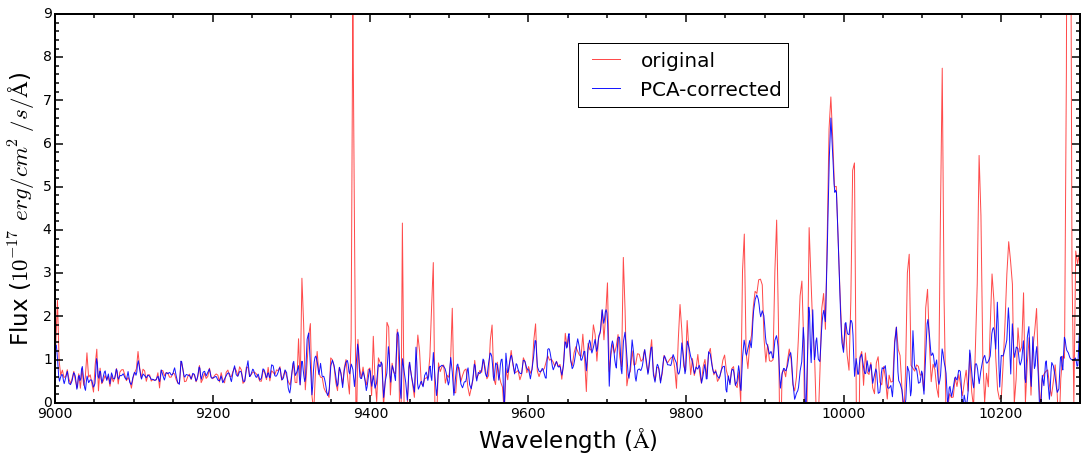

In [322]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.05, left=0.06, 
                    top=0.95, right=0.95)

ax = gca()
fontsize = 14
ax.minorticks_on()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xlabel('Wavelength ($\AA$)',      fontsize=23)
ax.set_ylabel('Flux ($10^{-17}\ erg/cm^2/s/\AA$)', fontsize=23)

ax.set_xlim(9000.0, 10300.0)
ax.set_ylim(0.0, 9.0)

ax.plot(w2, f2, '-', color='r', alpha=0.7, label='original')
ax.plot(lam, (f2bin - res2_skyrec), '-', color='b', alpha=0.9, label='PCA-corrected')


#ax.text(6000, 2.8, 'Difference of Sky Spectra', fontsize=25)

# Put legend on
ax.legend(loc=[0.51, 0.76], fontsize=20)